In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from plot_functions import *

In [2]:
name = "NPE_C"

In [3]:
# --- Load simulated data ---
alpha_IMF_obs = np.load(f"data/alpha_IMF_obs_{name}.npy")
log10_N_Ia_obs = np.load(f"data/log10_N_Ia_obs_{name}.npy")

In [4]:
simulations = 1000
N_stars = 1000
global_params = torch.tensor([[-2.3, -2.89]])

1000 simulations for each star


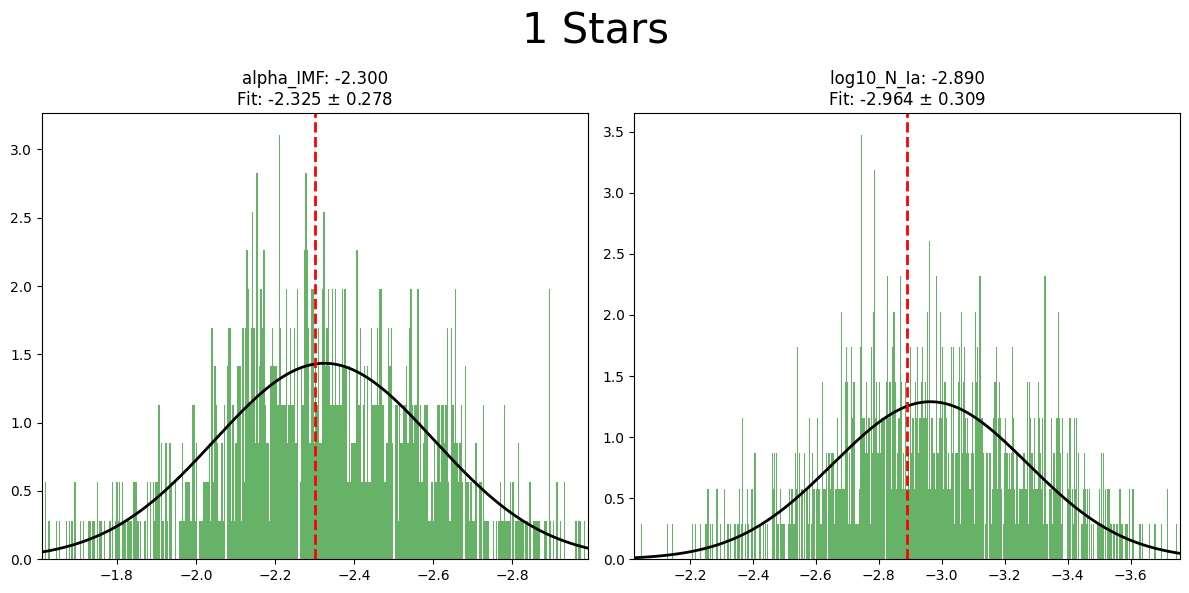

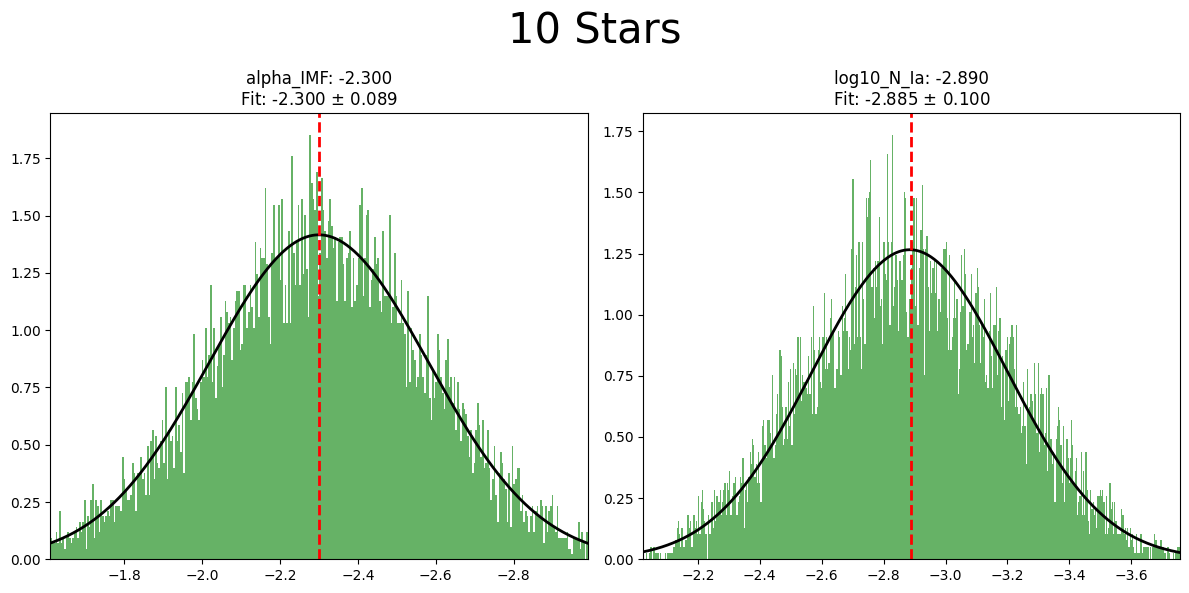

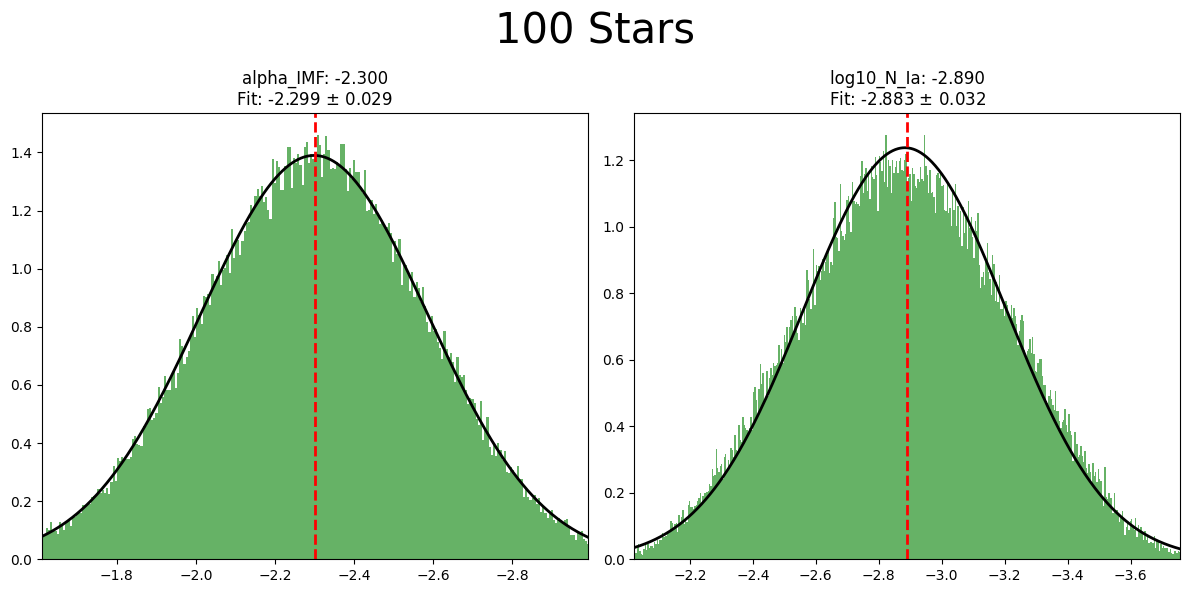

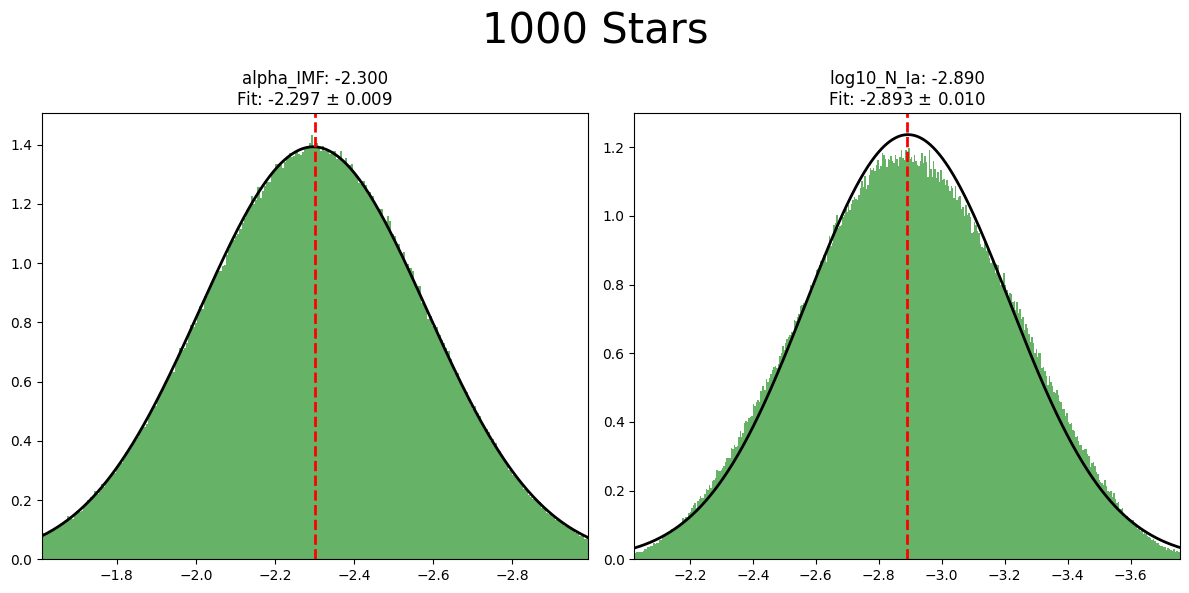

In [5]:
sims = np.array([1, 10, 100, 1000]) * simulations
print(f"{simulations} simulations for each star")
for i in sims:
    plot_1d_hist(x1=alpha_IMF_obs[0:i], x2=log10_N_Ia_obs[0:i], x_true=global_params[0], names=['alpha_IMF', 'log10_N_Ia'], simulations=simulations)

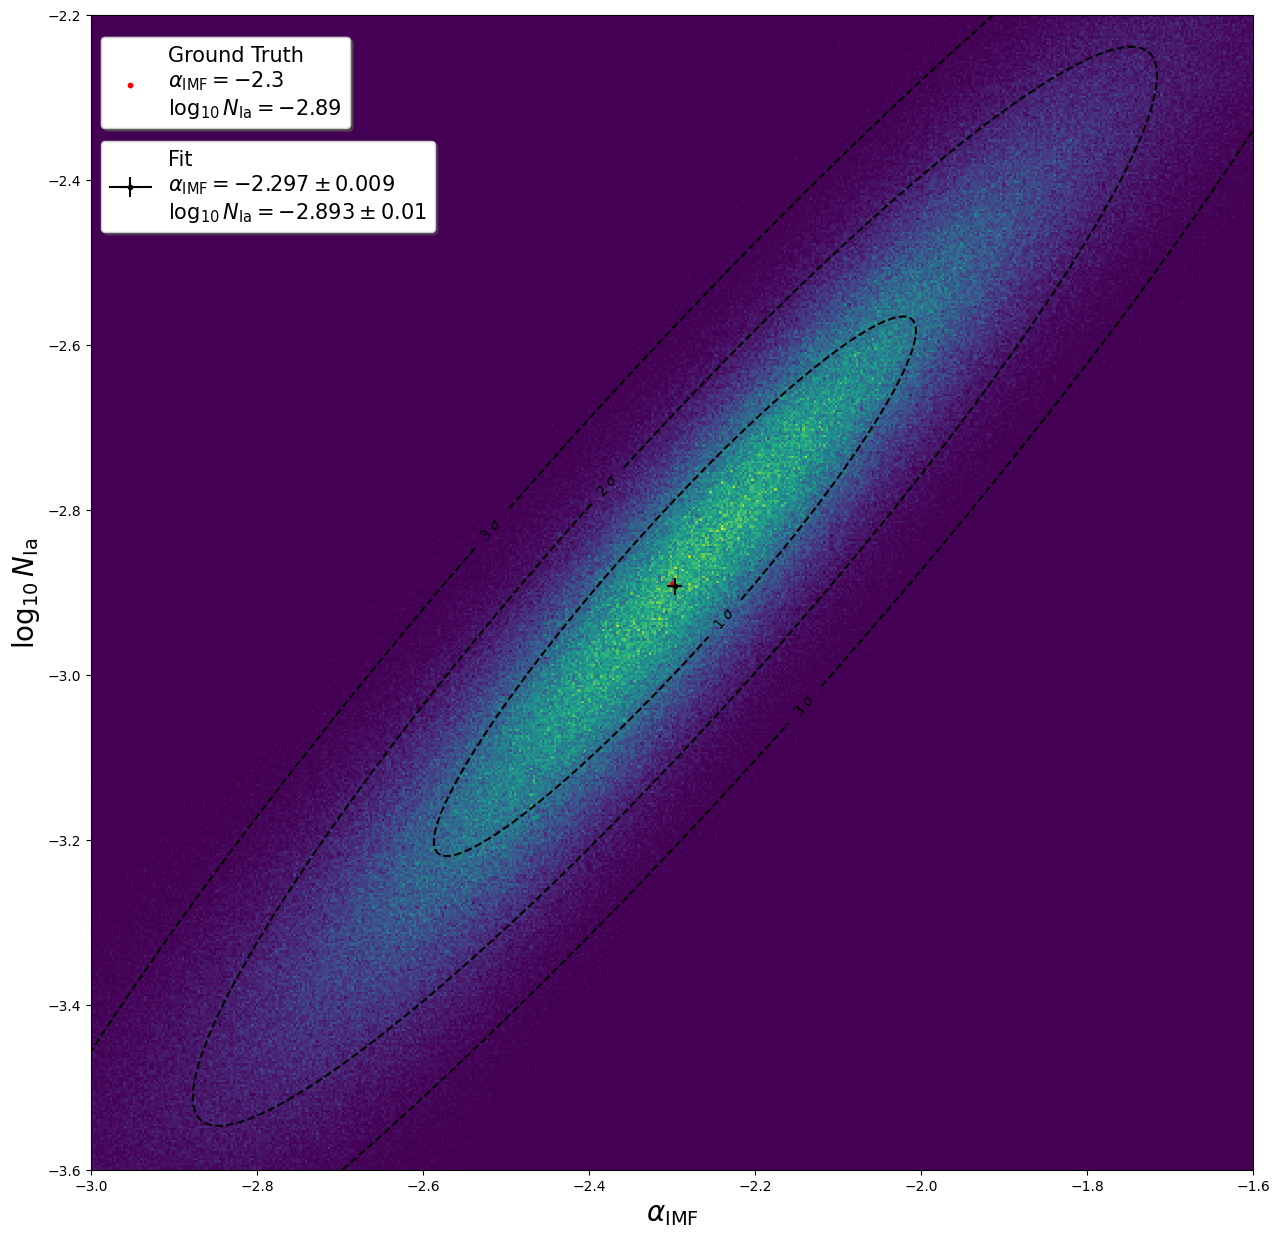

In [6]:
plot_2d_hist(alpha_IMF_obs, log10_N_Ia_obs, global_params[0], N_stars)

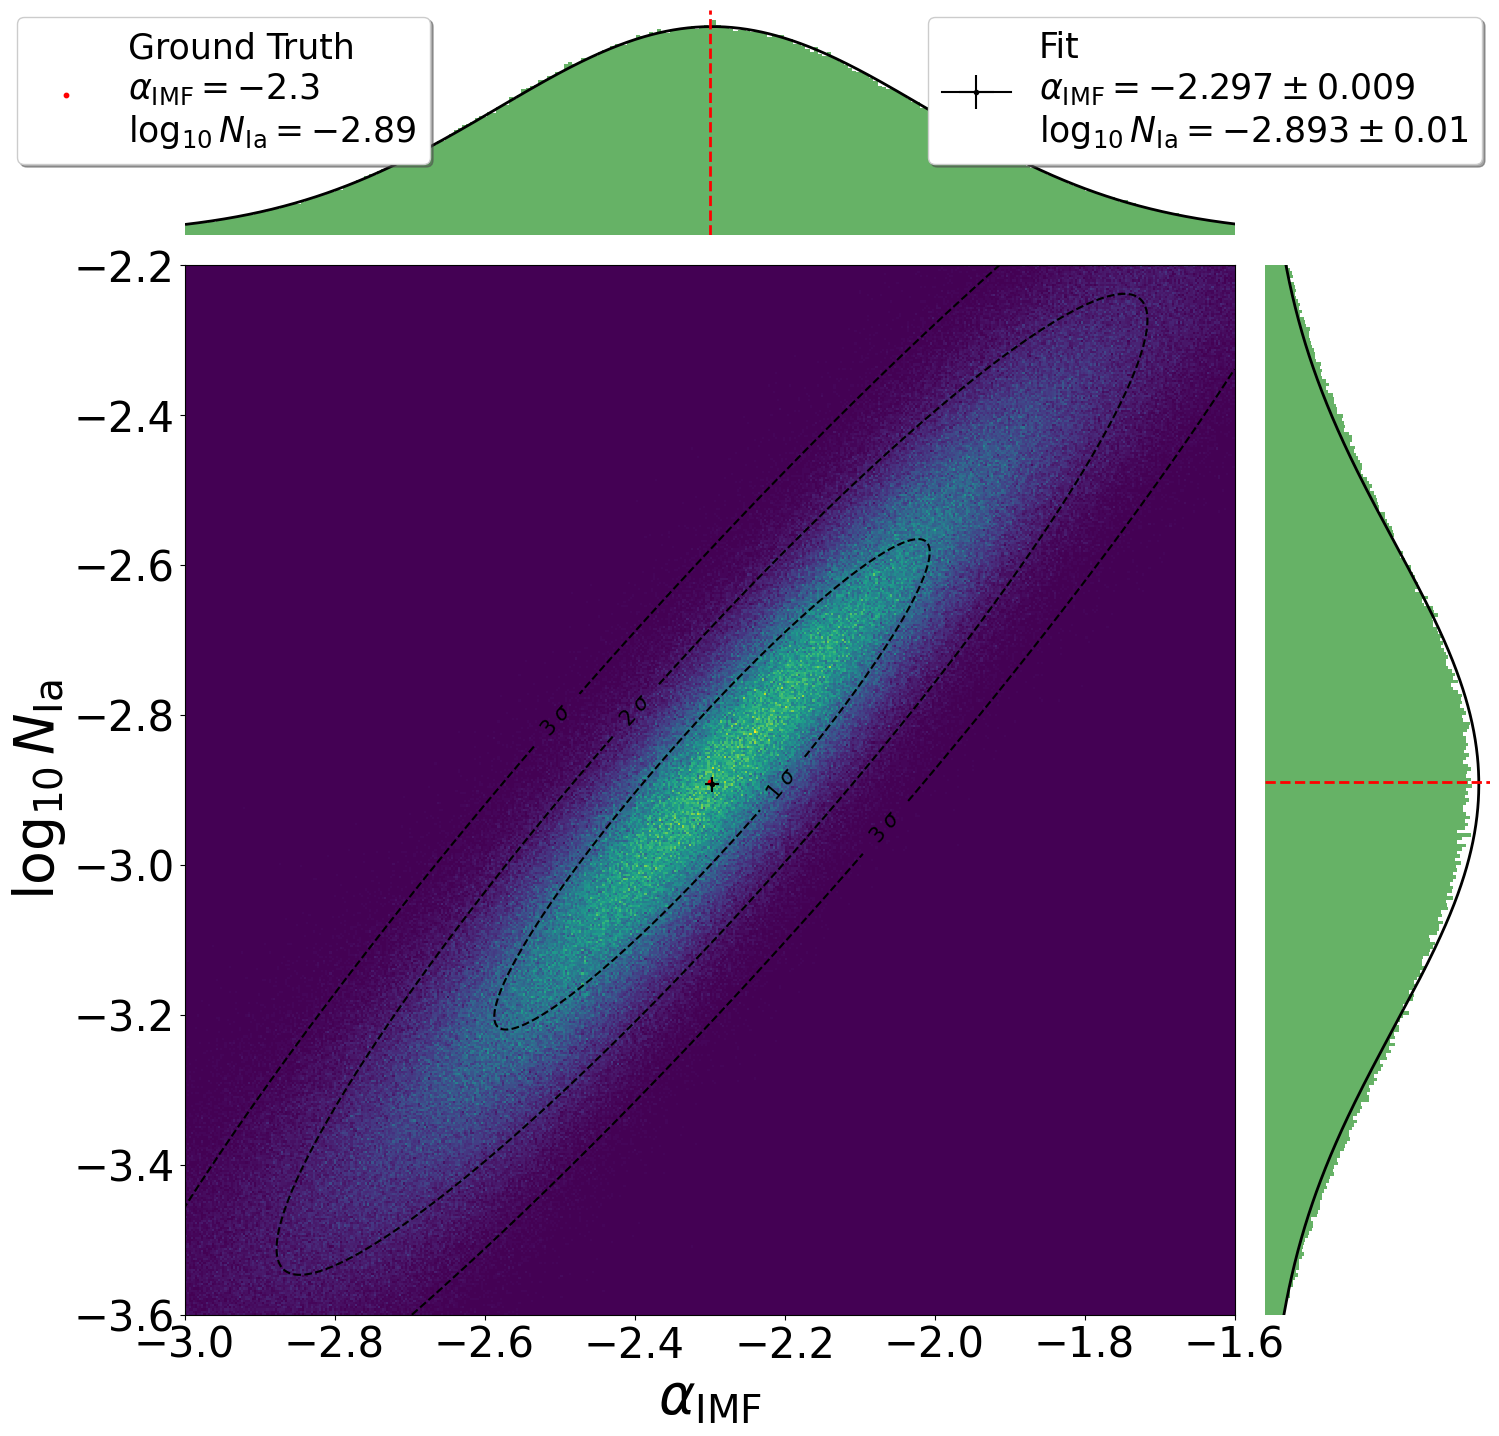

In [7]:
plot_2d_hist_sides(alpha_IMF_obs, log10_N_Ia_obs, global_params[0], N_stars)

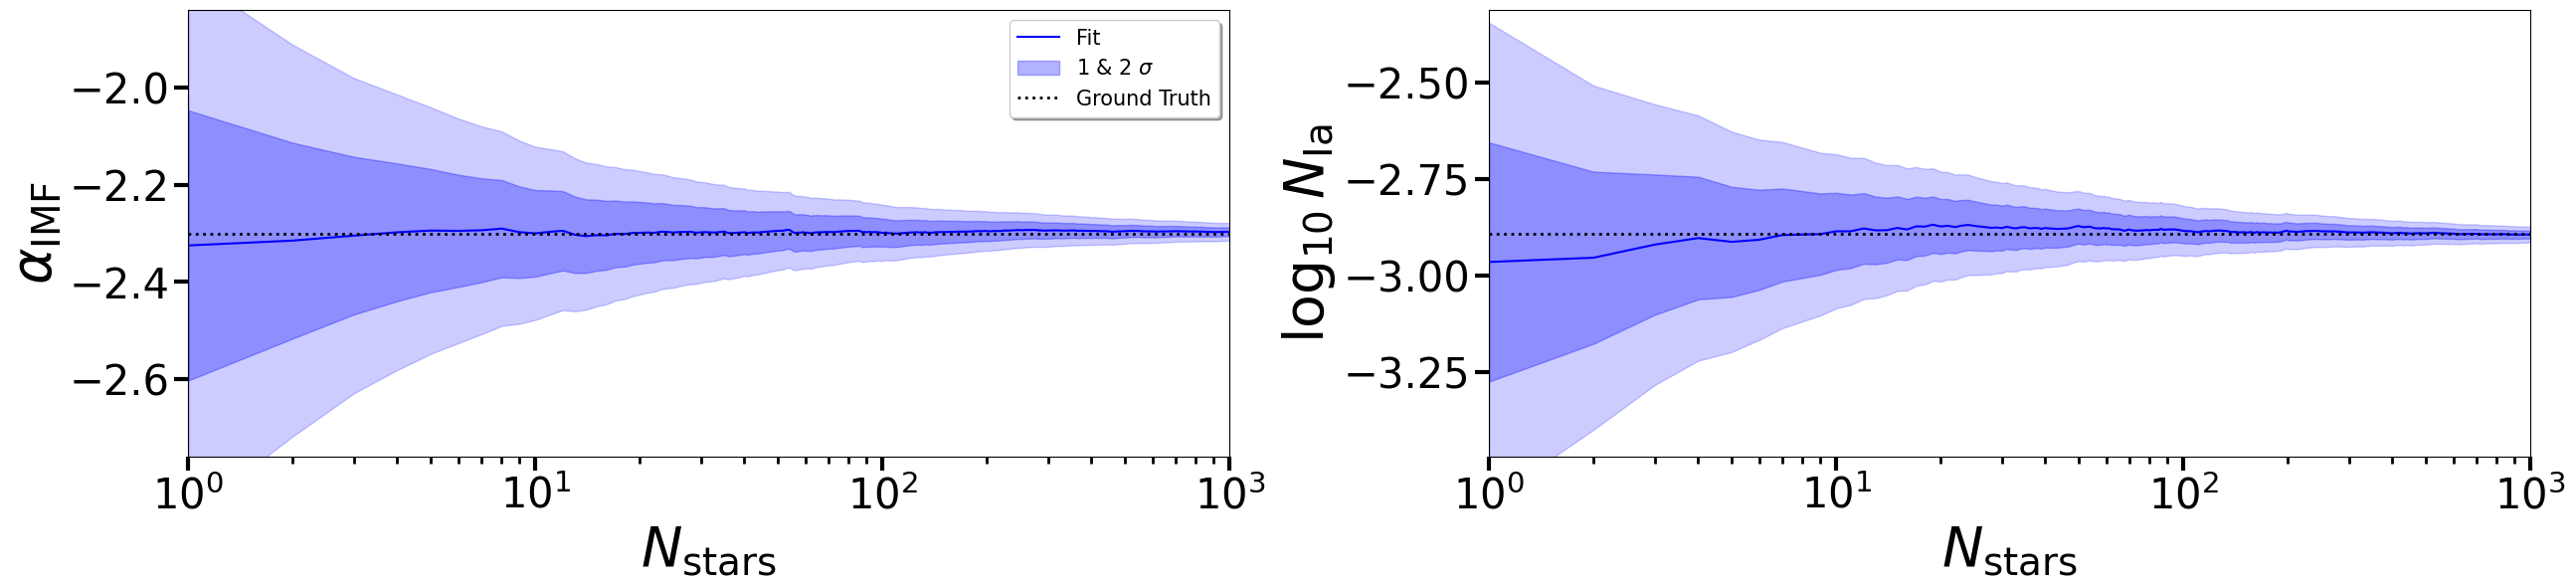

In [8]:
stars = np.arange(1,1000)
n_stars_plot(alpha_IMF_obs, log10_N_Ia_obs, global_params[0], stars)

## Compare to HMC

In [9]:
dat = np.load('data/chempy_data_paper/Inference_Output.npz', allow_pickle=True)

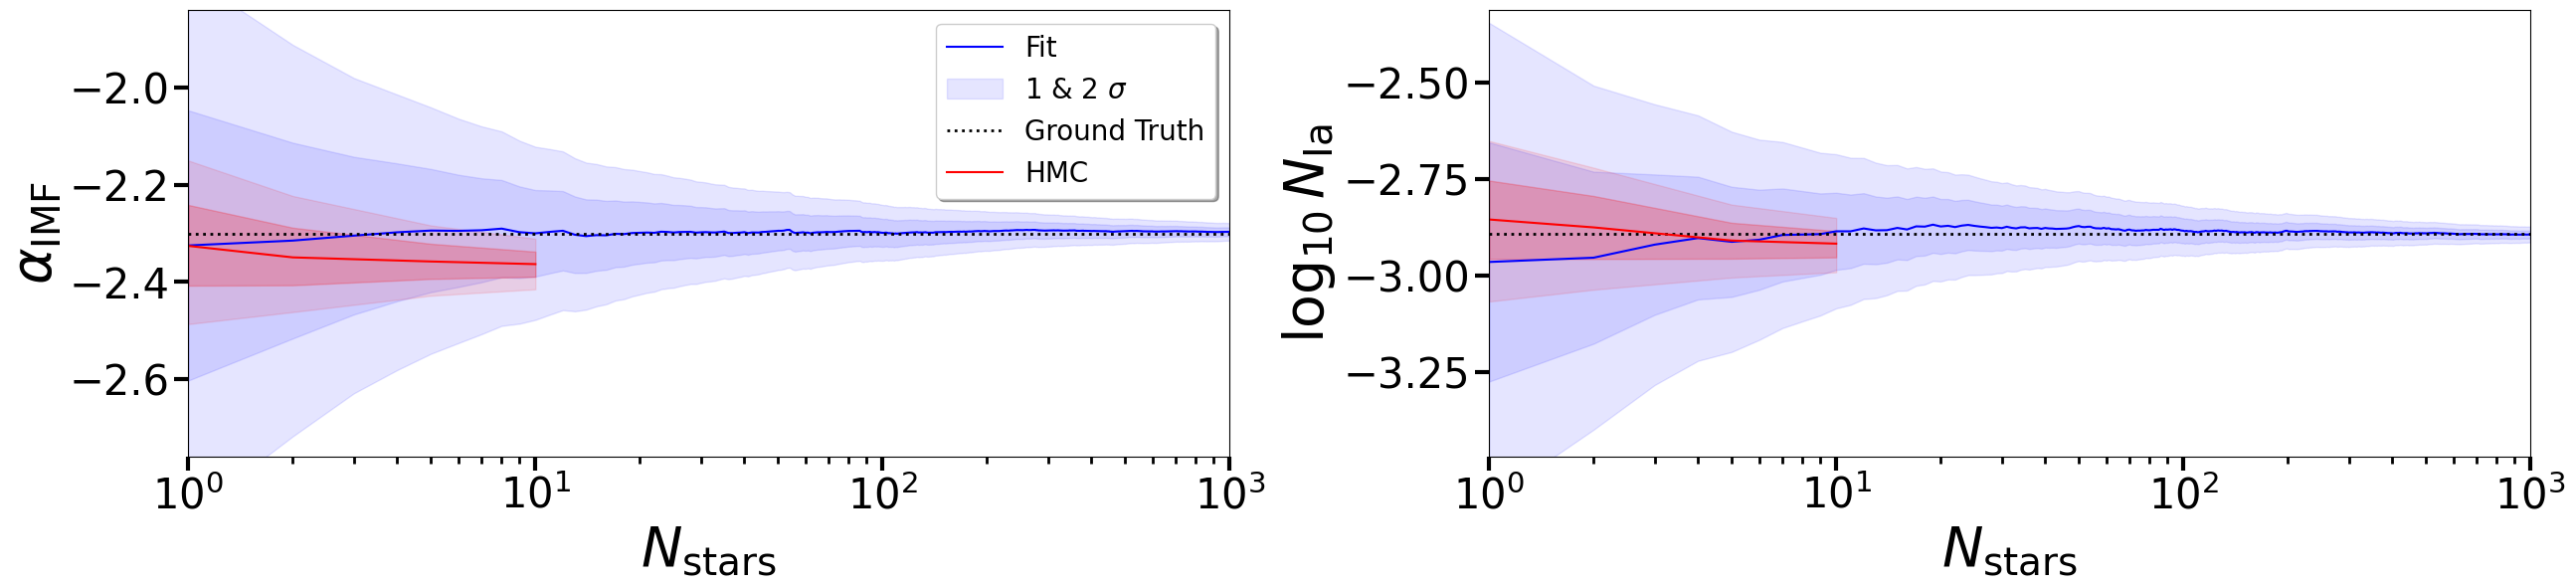

In [10]:
stars = np.arange(1,1000)
n_stars_plot_comp(alpha_IMF_obs, log10_N_Ia_obs, global_params[0], dat, stars)